In [1]:
import pathlib
import sys

import numpy as np
import optuna
import pandas as pd
import pyarrow.parquet as pq
import toml
import torch
from sklearn import preprocessing

sys.path.append("../..")

import json

from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    output_stats,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../../..")
from utils.utils import df_stats

## Papermill is used for executing notebooks in the CLI with multiple parameters
Here the `injected-parameters` cell is used to inject parameters into the notebook via papermill.
This enables multiple notebooks to be executed with different parameters, preventing to manually update parameters or have multiple copies of the notebook.

In [2]:
# Parameters
CELL_TYPE = "SHSY5Y"
CONTROL_NAME = "DMSO_0.100_DMSO_0.025"
TREATMENT_NAME = "LPS_100.000_DMSO_0.025"
MODEL_NAME = "DMSO_0.025_vs_LPS_100"
SHUFFLE = True

In [3]:
ml_configs_file = pathlib.Path("../../MLP_utils/binary_config.toml").resolve(
    strict=True
)
ml_configs = toml.load(ml_configs_file)
params = Parameters()
mlp_params = parameter_set(params, ml_configs)

# overwrite params via command line arguments from papermill
mlp_params.CELL_TYPE = CELL_TYPE
mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.CONTROL_NAME = CONTROL_NAME
mlp_params.TREATMENT_NAME = TREATMENT_NAME
mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.SHUFFLE = SHUFFLE

In [4]:
# Import Data
# set data file path under pathlib path for multi-system use

file_path = pathlib.Path(
    f"../../../data/{mlp_params.CELL_TYPE}_preprocessed_sc_norm.parquet"
).resolve(strict=True)

df = pq.read_table(file_path).to_pandas()

In [5]:
# # change model name to match shuffle
# if mlp_params.SHUFFLE:
#     mlp_params.MODEL_NAME = f'{mlp_params.MODEL_NAME}_shuffle'
# elif mlp_params.SHUFFLE != True:
#     pass
# else:
#     raise ValueError('SHUFFLE must be True or False')

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [6]:
# filter the oneb_Metadata_Treatment_Dose_Inhibitor_Dose column to only include the treatment and control via loc
df = df.loc[
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
        [mlp_params.TREATMENT_NAME, mlp_params.CONTROL_NAME]
    )
]


print("Selected Catagories are:")
print(df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
df_stats(df)

if mlp_params.DATA_SUBSET_OPTION == "True":
    df = df.sample(n=mlp_params.DATA_SUBSET_NUMBER)
    print("Data Subset Is On")
    print(f"Data is subset to {mlp_params.DATA_SUBSET_NUMBER}")
else:
    print("Data Subset Is Off")

Selected Catagories are:
['DMSO_0.100_DMSO_0.025' 'LPS_100.000_DMSO_0.025']
The dimensions of the data are: (51630, 1276)
Number of total missing values across all columns: 103260
Data Subset Is Off


In [7]:
np.random.seed(seed=0)
wells_to_hold = (
    df.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
    .agg(np.random.choice)["Metadata_Well"]
    .to_list()
)
df_holdout = df[df["Metadata_Well"].isin(wells_to_hold)]
df = df[~df["Metadata_Well"].isin(wells_to_hold)]


print("Wells held out for testing:", df_holdout["Metadata_Well"].unique())
print(
    "Wells to use for training, validation, and testing", df["Metadata_Well"].unique()
)

Wells held out for testing: ['I14' 'J21']
Wells to use for training, validation, and testing ['B14' 'C14' 'B15' 'C15' 'J14' 'I15' 'J15' 'J16' 'J17' 'J20']


In [8]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [9]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

#### Split Data - All Models can proceed through this point

In [10]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=mlp_params.TRAIN_PROPORTION_SPLIT,
    val_proportion=mlp_params.VALIDATION_PROPORTION_SPLIT,
    test_proportion=mlp_params.TEST_PROPORTION_SPLIT,
    # train_proportion=0.8,
    # val_proportion=0.1,
    # test_proportion=0.1,
    seed=0,
    params=mlp_params,
)

In [11]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [12]:
mlp_params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", mlp_params.IN_FEATURES)
if mlp_params.MODEL_TYPE == "Regression":
    mlp_params.OUT_FEATURES = 1
else:
    mlp_params.OUT_FEATURES = len(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

print("Number of out features: ", mlp_params.OUT_FEATURES)

if mlp_params.OUT_FEATURES > 2:
    mlp_params.MODEL_TYPE = "Multi_Class"
elif mlp_params.OUT_FEATURES == 2:
    mlp_params.OUT_FEATURES = mlp_params.OUT_FEATURES - 1
    mlp_params.MODEL_TYPE = "Binary_Classification"
elif mlp_params.OUT_FEATURES == 1:
    mlp_params.MODEL_TYPE = "Regression"
else:
    pass
print(mlp_params.MODEL_TYPE)

Number of in features:  1251
Number of out features:  2
Binary_Classification


In [13]:
mlp_params.SHUFFLE

True

In [14]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

In [15]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    mlp_params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    params,
    mlp_params.MODEL_NAME,
    mlp_params.SHUFFLE,
)
# get training_metrics
if mlp_params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

Adam
Epoch 0: Validation loss decreased (inf --> 0.330888).  Saving model ...
	 Train_Loss: 0.4284 Train_Acc: 72.191 Val_Loss: 0.3309  BEST VAL Loss: 0.3309  Val_Acc: 72.205

Epoch 1: Validation loss decreased (0.330888 --> 0.293202).  Saving model ...
	 Train_Loss: 0.3745 Train_Acc: 86.482 Val_Loss: 0.2932  BEST VAL Loss: 0.2932  Val_Acc: 91.352

Epoch 2: Validation loss decreased (0.293202 --> 0.262365).  Saving model ...
	 Train_Loss: 0.3367 Train_Acc: 90.235 Val_Loss: 0.2624  BEST VAL Loss: 0.2624  Val_Acc: 93.579

Epoch 3: Validation loss decreased (0.262365 --> 0.236542).  Saving model ...
	 Train_Loss: 0.3098 Train_Acc: 91.070 Val_Loss: 0.2365  BEST VAL Loss: 0.2365  Val_Acc: 94.141

Epoch 4: Validation loss decreased (0.236542 --> 0.216962).  Saving model ...
	 Train_Loss: 0.2876 Train_Acc: 92.324 Val_Loss: 0.2170  BEST VAL Loss: 0.2170  Val_Acc: 94.446

Epoch 5: Validation loss decreased (0.216962 --> 0.206429).  Saving model ...
	 Train_Loss: 0.2710 Train_Acc: 92.608 Val_Loss

In [16]:
# create a dataframe to store the model stats
model_stats_df = pd.DataFrame(
    columns=[
        "treatments_tested",
        "model",
        "group",
        "shuffled_data",
        "PR_Threshold",
        "Precision",
        "Recall",
    ]
)
model_stats_df

,treatments_tested,model,group,shuffled_data,PR_Threshold,Precision,Recall


/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:997: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:998: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


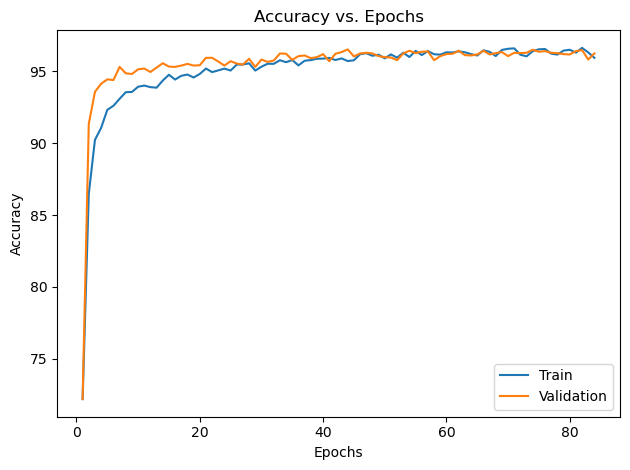

In [17]:
if mlp_params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:997: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:998: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


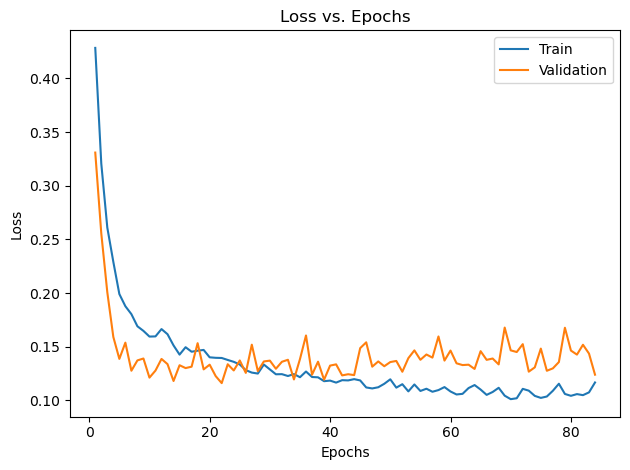

In [18]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

In [19]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

In [20]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    Y_train,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.72      0.71      0.72     24644
           1       0.28      0.28      0.28      9489

    accuracy                           0.59     34133
   macro avg       0.50      0.50      0.50     34133
weighted avg       0.60      0.59      0.60     34133



In [21]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "train"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

In [22]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

In [23]:
mlp_params.SHUFFLE

True

In [24]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    Y_val,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_validation",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      3081
           1       0.29      0.30      0.29      1186

    accuracy                           0.60      4267
   macro avg       0.51      0.51      0.51      4267
weighted avg       0.60      0.60      0.60      4267



In [25]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "validation"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

In [26]:
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=mlp_params.MODEL_NAME
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=mlp_params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.72      0.73      0.73      3081
           1       0.27      0.26      0.27      1186

    accuracy                           0.60      4267
   macro avg       0.50      0.50      0.50      4267
weighted avg       0.60      0.60      0.60      4267



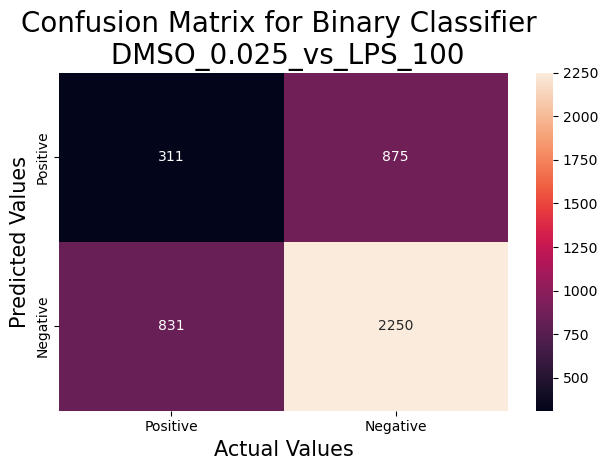

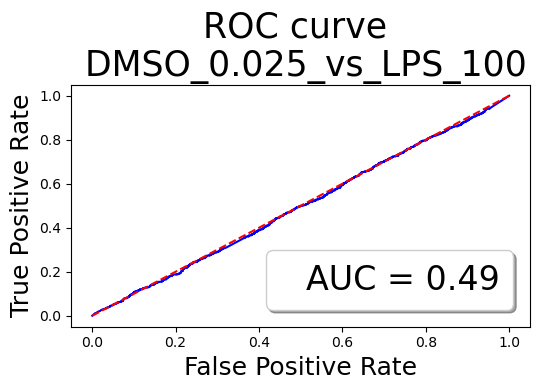

In [27]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [28]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    Y_test,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_test",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.72      0.73      0.73      3081
           1       0.27      0.26      0.27      1186

    accuracy                           0.60      4267
   macro avg       0.50      0.50      0.50      4267
weighted avg       0.60      0.60      0.60      4267



In [29]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "test"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

## Test the hold out wells

In [30]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df_holdout.columns[df_holdout.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df_holdout[df_metadata]
df_values = df_holdout.drop(columns=df_metadata)

In [31]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

              precision    recall  f1-score   support

           0       0.54      0.60      0.57      4837
           1       0.46      0.40      0.43      4126

    accuracy                           0.51      8963
   macro avg       0.50      0.50      0.50      8963
weighted avg       0.50      0.51      0.50      8963



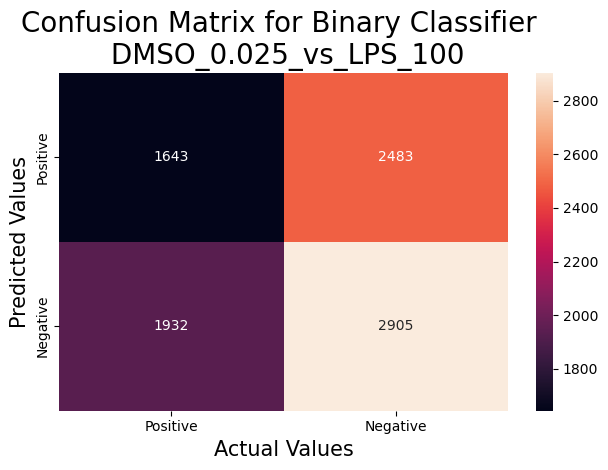

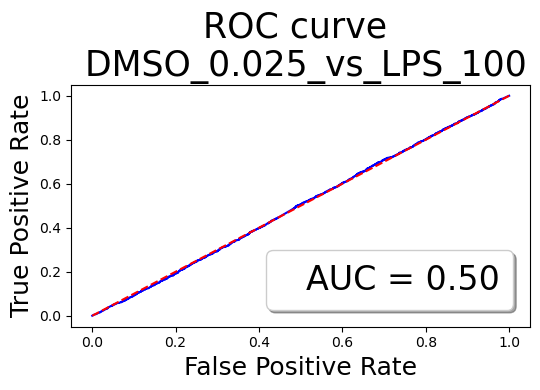

In [32]:
test_data = Dataset_formatter(
    torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
)

# convert data class into a dataloader to be compatible with pytorch
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=mlp_params.MODEL_NAME
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=mlp_params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(df_values_Y):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        df_values_Y,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        df_values_Y,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [33]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    df_values_Y,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_hold_out",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.54      0.60      0.57      4837
           1       0.46      0.40      0.43      4126

    accuracy                           0.51      8963
   macro avg       0.50      0.50      0.50      8963
weighted avg       0.50      0.51      0.50      8963



In [34]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "holdout"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

In [35]:
model_stats_df

,treatments_tested,model,group,shuffled_data,PR_Threshold,Precision,Recall
0,DMSO_0.100_DMSO_0.025 vs. LPS_100.000_DMSO_0.025,DMSO_0.025_vs_LPS_100,train,True,0.0,0.278001,1.000000
1,DMSO_0.100_DMSO_0.025 vs. LPS_100.000_DMSO_0.025,DMSO_0.025_vs_LPS_100,train,True,0.0,0.277471,0.830541
2,DMSO_0.100_DMSO_0.025 vs. LPS_100.000_DMSO_0.025,DMSO_0.025_vs_LPS_100,train,True,0.0,0.277480,0.830541
3,DMSO_0.100_DMSO_0.025 vs. LPS_100.000_DMSO_0.025,DMSO_0.025_vs_LPS_100,train,True,0.0,0.277490,0.830541
4,DMSO_0.100_DMSO_0.025 vs. LPS_100.000_DMSO_0.025,DMSO_0.025_vs_LPS_100,train,True,0.0,0.277465,0.830435
...,...,...,...,...,...,...,...
8048,DMSO_0.100_DMSO_0.025 vs. LPS_100.000_DMSO_0.025,DMSO_0.025_vs_LPS_100,holdout,True,1.0,0.395349,0.008240
8049,DMSO_0.100_DMSO_0.025 vs. LPS_100.000_DMSO_0.025,DMSO_0.025_vs_LPS_100,holdout,True,1.0,0.391304,0.006544
8050,DMSO_0.100_DMSO_0.025 vs. LPS_100.000_DMSO_0.025,DMSO_0.025_vs_LPS_100,holdout,True,1.0,0.431034,0.006059
8051,DMSO_0.100_DMSO_0.025 vs. LPS_100.000_DMSO_0.025,DMSO_0.025_vs_LPS_100,holdout,True,1.0,0.487179,0.004605


In [36]:
# set path for the model training metrics
metrics_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
metrics_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
metrics_file = pathlib.Path(f"{metrics_path}/training_metrics.csv")
if metrics_file.exists():
    metrics_df = pd.read_csv(metrics_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, model_stats_df], axis=0)
        metrics_df.to_csv(metrics_file, index=False)
else:
    model_stats_df.to_csv(metrics_file, index=False)